In [1]:
import numpy as np
import random
from Data_import_calm_test_montcarlo import data_frame
from model_evaluation import *
from sklearn.metrics import roc_curve, auc
from scipy.special import kv #modified bessel function
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io as scio
from traditional_methods import traditional_methods
np.random.seed(1)
random.seed(1)
dataset_mont = scio.loadmat('dataset_mont.mat')
train_x = dataset_mont['train_x']
train_y = dataset_mont['train_y'][0]
calm_test_x = dataset_mont['calm_test_x']
pilot_test_x = dataset_mont['pilot_test_x']
test_y = dataset_mont['test_y'][0]
trad_train_ = traditional_methods(train_x,train_y)
speed_ = trad_train_.speed()
edr_structure_ = trad_train_.edr_structure_function()
edr_sampling_ = trad_train_.edr_sampling_scale()
speed_fluct_ = trad_train_.speed_fluct()
f_factor_ = trad_train_.f_factor()
s_factor_ = trad_train_.s_factor()
x_features = np.hstack((speed_,edr_sampling_,speed_fluct_,f_factor_,s_factor_)).reshape(-1,5)#edr_structure_,
features_name_train = ['speed','edr_sampling','speed_fluct','f_factor','s_factor']#'edr_structure',

def test_traditional_feature(test_x_i):
    trad_test_ = traditional_methods(test_x_i,test_y)
    speed_ = trad_test_.speed()
    edr_structure_ = trad_test_.edr_structure_function()
    edr_sampling_ = trad_test_.edr_sampling_scale()
    speed_fluct_ = trad_test_.speed_fluct()
    f_factor_ = trad_test_.f_factor()
    s_factor_ = trad_test_.s_factor()
    test_x_features = np.hstack((speed_,edr_sampling_,speed_fluct_,f_factor_,s_factor_)).reshape(-1,5)#edr_structure_,
    return test_x_features

c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [5]:
# linear svm based on the velocity record
from sklearn.svm import SVC
# pod_mont = []
csi_mont = []
far_mont = []
pod_mont = []
svc = SVC(kernel='linear')
svc_clf = svc.fit(train_x,train_y)
predict_train = svc_clf.decision_function(train_x)
roc_auc_, pod_, podN_, auc_threshold_ = trad_train_.model_eval(predict_train)
for mont_i in range(len(calm_test_x)):
    test_x = np.vstack((calm_test_x[mont_i], pilot_test_x))
    predict_test = svc_clf.decision_function(test_x)
    predict_test = predict_test.reshape(-1,1)
    pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(predict_test>auc_threshold_,test_y.reshape(-1,1),1)
    csi_mont.append(csi_)
    far_mont.append(far_)
    pod_mont.append(pod_)

# plt.plot(csi_mont,label='csi')
# plt.plot(far_mont,label='far')
# plt.plot(pod_mont,label='pod')
# plt.legend()
# scio.savemat('original_mont.mat',{'csi_mont':csi_mont,
#                           'far_mont':far_mont,
#                           'pod_mont':pod_mont})

In [4]:
def traditional(train_x_features,test_x_features,test_y):
    csi_s_test_auc = []
    csi_s_test_thre = []
    far_s_test_auc = []
    far_s_test_thre = []
    pod_s_test_auc = []
    pod_s_test_thre = []
    thres = [9,0.01,7.5,0.105,0.27]
    for feature_i in range(test_x_features.shape[1]):
        feature_test = test_x_features[::,feature_i]
        feature_train = train_x_features[::,feature_i]
        feature_train = feature_train.reshape(-1,1)
        feature_test = feature_test.reshape(-1,1)
        roc_auc_, pod_, podN_, auc_threshold_ = trad_train_.model_eval(feature_train)
        pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(feature_test>auc_threshold_,test_y.reshape(-1,1),1)
        csi_s_test_auc.append(csi_)
        far_s_test_auc.append(far_)
        pod_s_test_auc.append(pod_)
        pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(feature_test>thres[feature_i],test_y.reshape(-1,1),1)
        csi_s_test_thre.append(csi_)
        far_s_test_thre.append(far_)
        pod_s_test_thre.append(pod_)
    return csi_s_test_auc,csi_s_test_thre,far_s_test_auc,far_s_test_thre,pod_s_test_auc,pod_s_test_thre
traditional_csi_s_test_auc = []
traditional_csi_s_test_thre = []
traditional_far_s_test_auc = []
traditional_far_s_test_thre = []
traditional_pod_s_test_auc = []
traditional_pod_s_test_thre = []
for mont_i in range(len(calm_test_x)):
    test_x_i = np.vstack((calm_test_x[mont_i], pilot_test_x))
    test_x_features_i = test_traditional_feature(test_x_i)
    csi_s_test_auc,csi_s_test_thre,far_s_test_auc,far_s_test_thre,pod_s_test_auc,pod_s_test_thre = traditional(x_features,test_x_features_i,test_y)
    traditional_csi_s_test_auc.append(csi_s_test_auc)
    traditional_csi_s_test_thre.append(csi_s_test_thre)
    traditional_far_s_test_auc.append(far_s_test_auc)
    traditional_far_s_test_thre.append(far_s_test_thre)
    traditional_pod_s_test_auc.append(pod_s_test_auc)
    traditional_pod_s_test_thre.append(pod_s_test_thre)
# scio.savemat('traditional_mont.mat',{'traditional_csi_s_test_auc':traditional_csi_s_test_auc,
#                           'traditional_csi_s_test_thre':traditional_csi_s_test_thre,
#                           'traditional_far_s_test_auc':traditional_far_s_test_auc,
#                           'traditional_far_s_test_thre':traditional_far_s_test_thre,
#                           'traditional_pod_s_test_auc':traditional_pod_s_test_auc,
#                           'traditional_pod_s_test_thre':traditional_pod_s_test_thre})

c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estima

In [ ]:
# svm based on the six traditional criteria
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
decision_tree = DecisionTreeClassifier()
tree_clf = decision_tree.fit(x_features,train_y)
svc = SVC(kernel='linear')
svc_clf = svc.fit(x_features,train_y)
predict_train = svc_clf.decision_function(x_features)
roc_auc_, pod_, podN_, auc_threshold_ = trad_train_.model_eval(predict_train)

def feature_selection_from_traditional_svm(test_x_features,test_y):
    predict_test = svc_clf.decision_function(test_x_features)
    predict_test = predict_test.reshape(-1,1)
    pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(predict_test>auc_threshold_,test_y.reshape(-1,1),1)
    return pod_, far_, csi_
# pod_tree_mont = []
# far_tree_mont = []
# csi_tree_mont = []
pod_svm_mont = []
far_svm_mont = []
csi_svm_mont = []
for mont_i in range(len(calm_test_x)):
    test_x_i = np.vstack((calm_test_x[mont_i], pilot_test_x))
    test_x_features_i = test_traditional_feature(test_x_i)
    x_features_test_i = test_x_features_i.reshape(-1,5)
    # pod_tree, far_tree, csi_tree = feature_selection_from_traditional_tree(x_features_test_i,test_y)
    pod_svm, far_svm, csi_svm = feature_selection_from_traditional_svm(x_features_test_i,test_y)
    # pod_tree_mont.append(pod_tree)   
    # far_tree_mont.append(far_tree)
    # csi_tree_mont.append(csi_tree)
    pod_svm_mont.append(pod_svm)
    far_svm_mont.append(far_svm)
    csi_svm_mont.append(csi_svm)
# scio.savemat('feature_selection_from_traditional_svm_tree.mat',
#              {'pod_tree_mont':pod_tree_mont,
#               'far_tree_mont':far_tree_mont,
#               'csi_tree_mont':csi_tree_mont,
#               'pod_svm_mont':pod_svm_mont,
#               'far_svm_mont':far_svm_mont,
#               'csi_svm_mont':csi_svm_mont})

c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estima

In [7]:
# establish feature library
class addtional_methods(object):
    # Turbulence diagnostic
    def __init__(self, velocity):
        self.velocity = velocity
    def range_v_cal(self):
        return np.max(self.velocity, axis = 1)-np.min(self.velocity, axis = 1)
    def strcture_v_cal(self,q,r):
        # q-th order
        # r: scale of the structure function
        structure_func_sum = np.zeros((self.velocity.shape[0],1))
        structure_func = np.zeros((self.velocity.shape[0],1))
        count_s = 0
        for j in range(115-r):
            start_ = self.velocity[:,j]  
            end_ = self.velocity[:,j+r]
            structure_func_sum[:,0] = structure_func_sum[:,0] + (start_-end_)**q
            count_s = count_s + 1
        structure_func[:,0] = structure_func_sum[:,0]/count_s
        return structure_func
    def correlation_cal(self,r):
        count_s = 0
        corr_func_sum = np.zeros((self.velocity.shape[0],1))
        corr_func = np.zeros((self.velocity.shape[0],1))
        for j in range(115-r):
            start_ = self.velocity[:,j]  
            end_ = self.velocity[:,j+r]
            corr_func_sum[:,0] = corr_func_sum[:,0] + (start_*end_)
            count_s = count_s + 1
        corr_func[:,0] = corr_func_sum[:,0]/count_s
        return corr_func
def additional_features_cal(x):
    add_meth = addtional_methods(x)
    additional_features = []
    additional_features_name = []
    # for r in range(2,115):
    #     additional_features.append(add_meth.correlation_cal(r)[::,0])
    #     additional_features_name.append(f'corr_{r}')
    for q in range(2,3):
        for r in range(2,115):
            additional_features.append(add_meth.strcture_v_cal(q,r)[::,0])
            additional_features_name.append(f'struct_{r}')
    return additional_features,additional_features_name
# np.array(additional_features).T.shape
additional_features_train,additional_features_name_train = additional_features_cal(train_x)
x_features_add_train = np.hstack((np.array(additional_features_train).T,x_features.reshape(-1,5)))#
all_features_names = additional_features_name_train+features_name_train

In [8]:
#  SVM-PCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
pcasvc_para_struc_2nd = scio.loadmat(f'pcasvc_para_struc_2nd.mat')
mu_all_dims = pcasvc_para_struc_2nd['mu_all_dims']
w_all_dims = pcasvc_para_struc_2nd['w_all_dims']
b_all_dims = pcasvc_para_struc_2nd['b_all_dims'][0]
def pca_svm(x_features_add_train,train_y,x_features_add_test,test_y):
    csi_s_test = []
    pod_s_test = []
    far_s_test = []
    for pca_dim_1 in range(2,25):
        mu = mu_all_dims[pca_dim_1-2]
        w = w_all_dims[pca_dim_1-2]
        b = b_all_dims[pca_dim_1-2]
        predict_test = np.matmul(x_features_add_test-mu,w)+ b
        pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(predict_test>auc_threshold_,test_y.reshape(-1,1),1)
        pod_s_test.append(pod_)
        far_s_test.append(far_)
        csi_s_test.append(csi_)
    return pod_s_test, far_s_test, csi_s_test
pod_pca_svm_mont = []
far_pca_svm_mont = []
csi_pca_svm_mont = []
for mont_i in range(len(calm_test_x)):
    test_x_i = np.vstack((calm_test_x[mont_i], pilot_test_x))
    test_x_features_i = test_traditional_feature(test_x_i)
    additional_features_test,_ = additional_features_cal(test_x_i)
    x_features_add_test_i = np.hstack((np.array(additional_features_test).T,test_x_features_i.reshape(-1,5)))#
    pod_pca_dim, far_pca_dim, csi_pca_dim = pca_svm(x_features_add_train,train_y,x_features_add_test_i,test_y)
    pod_pca_svm_mont.append(pod_pca_dim)
    far_pca_svm_mont.append(far_pca_dim)
    csi_pca_svm_mont.append(csi_pca_dim)
scio.savemat('pca_svm_struc_2nd_mont.mat',{'pod_pca_svm_mont':pod_pca_svm_mont,
                                       'far_pca_svm_mont':far_pca_svm_mont,
                                       'csi_pca_svm_mont':csi_pca_svm_mont})

In [9]:
# RN-NN
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import torch as t
from torch import nn
class NonLinear(nn.Module):
    def __init__(self,pca_dim_1,pca_dim_2) -> None:
        super().__init__()
        self.W = nn.Parameter(t.randn(pca_dim_1,1))
        self.b = nn.Parameter(t.randn(1))
        self.W_nonlinear = nn.Parameter(t.randn(pca_dim_2,1))#+in_features
        self.b_nonlinear = nn.Parameter(t.randn(1))
    def forward(self,x_feature,x_input):
        x = t.matmul(x_feature,self.W)
        y = x+self.b.expand_as(x)
        # x = t.concat([x_feature,x_input],dim=1)
        x = x_input
        y_nonlinear = t.relu(t.matmul(x,self.W_nonlinear)+self.b_nonlinear.expand_as(t.matmul(x,self.W_nonlinear)))
        return t.sigmoid(y+y_nonlinear),y,y_nonlinear
    def compute_regular_loss(self):
        return t.abs(self.W).sum()+t.pow(self.W_nonlinear,2).sum()+t.pow(self.b_nonlinear,2).sum()
my_nn_para_struc_2nd = scio.loadmat(f'my_nn_para_struc_2nd.mat')
mu_all_dims = my_nn_para_struc_2nd['mu_all_dims']
w_all_dims = my_nn_para_struc_2nd['w_all_dims']
b_all_dims = my_nn_para_struc_2nd['b_all_dims'][0]
w_nonlinear_all_dims = my_nn_para_struc_2nd['w_nonlinear_all_dims']
b_nonlinear_all_dims = my_nn_para_struc_2nd['b_nonlinear_all_dims']
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
def relu(x):
    y = np.clip(x, a_min = 0., a_max = None)
    return y
def my_nn(x_features_add_train,x_features_add_test,test_y,test_x):
    csi_s_test = []
    pod_s_test = []
    far_s_test = []
    for pca_dim_1 in range(2,25):
        mu = mu_all_dims[pca_dim_1-2]
        w = w_all_dims[pca_dim_1-2]
        b = b_all_dims[pca_dim_1-2]
        w_nonlinear = w_nonlinear_all_dims[pca_dim_1-2]
        b_nonlinear = b_nonlinear_all_dims[pca_dim_1-2]
        predict_test = sigmoid(np.matmul(x_features_add_test-mu,w)+b+relu(np.matmul(test_x,w_nonlinear)+b_nonlinear))

        pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(predict_test>0.5,test_y.reshape(-1,1),1)
        pod_s_test.append(pod_)
        far_s_test.append(far_)
        csi_s_test.append(csi_)
    return pod_s_test,far_s_test,csi_s_test
pod_my_nn_mont = []
far_my_nn_mont = []
csi_my_nn_mont = []
for mont_i in range(len(calm_test_x)):
    test_x_i = np.vstack((calm_test_x[mont_i], pilot_test_x))
    test_x_features_i = test_traditional_feature(test_x_i)
    additional_features_test,_ = additional_features_cal(test_x_i)
    x_features_add_test_i = np.hstack((np.array(additional_features_test).T,test_x_features_i.reshape(-1,5)))#
    pod_s_test,far_s_test,csi_s_test = my_nn(x_features_add_train,x_features_add_test_i,test_y,test_x_i)
    pod_my_nn_mont.append(pod_s_test)
    far_my_nn_mont.append(far_s_test)
    csi_my_nn_mont.append(csi_s_test)
# scio.savemat('my_nn_struc_2nd_mont.mat',{'pod_my_nn_mont':pod_my_nn_mont,
#                                              'far_my_nn_mont':far_my_nn_mont,
#                                              'csi_my_nn_mont':csi_my_nn_mont})

c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
# RN-NN-Intensity
my_nn_para_struc_2nd_intensity_para10 = scio.loadmat('my_nn_para_struc_2nd_intensity_para10.mat')
mu_all_dims = my_nn_para_struc_2nd_intensity_para10['mu_all_dims']
w_all_dims = my_nn_para_struc_2nd_intensity_para10['w_all_dims']
b_all_dims = my_nn_para_struc_2nd_intensity_para10['b_all_dims']
w_nonlinear_all_dims = my_nn_para_struc_2nd_intensity_para10['w_nonlinear_all_dims']
b_nonlinear_all_dims = my_nn_para_struc_2nd_intensity_para10['b_nonlinear_all_dims']
margin_s = my_nn_para_struc_2nd_intensity_para10['margin_s']
e_s = my_nn_para_struc_2nd_intensity_para10['e_s']
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
def relu(x):
    y = np.clip(x, a_min = 0., a_max = None)
    return y
def my_nn_intensity(x_features_add_test,test_y,test_x):
    csi_s_test = []
    pod_s_test = []
    far_s_test = []
    margin_set = 0.2
    idxs = np.where(margin_s==margin_set)[1]
    for idx in idxs:
        # print(e_s[0,idx])
        mu = mu_all_dims[idx]
        w = w_all_dims[idx]
        b = b_all_dims[0,idx]
        w_nonlinear = w_nonlinear_all_dims[idx]
        b_nonlinear = b_nonlinear_all_dims[idx]
        predict_test = sigmoid(np.matmul(x_features_add_test-mu,w)+b+relu(np.matmul(test_x,w_nonlinear)+b_nonlinear))
        pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(predict_test>0.5,test_y.reshape(-1,1),1)
        pod_s_test.append(pod_)
        far_s_test.append(far_)
        csi_s_test.append(csi_)
    return pod_s_test,far_s_test,csi_s_test
pod_my_nn_mont = []
far_my_nn_mont = []
csi_my_nn_mont = []
for mont_i in range(len(calm_test_x)):
    test_x_i = np.vstack((calm_test_x[mont_i], pilot_test_x))
    test_x_features_i = test_traditional_feature(test_x_i)
    additional_features_test,_ = additional_features_cal(test_x_i)
    x_features_add_test_i = np.hstack((np.array(additional_features_test).T,test_x_features_i.reshape(-1,5)))#
    pod_s_test,far_s_test,csi_s_test = my_nn_intensity(x_features_add_test_i,test_y,test_x_i)
    pod_my_nn_mont.append(pod_s_test)
    far_my_nn_mont.append(far_s_test)
    csi_my_nn_mont.append(csi_s_test)
scio.savemat('my_nn_struc_2nd_mont_pcadim10_intensity_margin02.mat',{'pod_my_nn_mont':pod_my_nn_mont,
                                             'far_my_nn_mont':far_my_nn_mont,
                                             'csi_my_nn_mont':csi_my_nn_mont})


d:\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
d:\anaconda\envs\pytorch_env\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


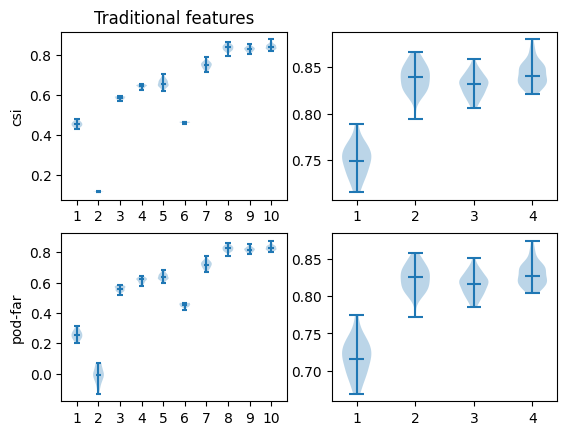

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio


%matplotlib inline

original_mont = scio.loadmat('original_mont.mat')
original_csi_mont = original_mont['csi_mont']
original_far_mont = original_mont['far_mont']
original_pod_mont = original_mont['pod_mont']
traditional_mont = scio.loadmat('traditional_mont.mat')
traditional_csi_s_test_auc = traditional_mont['traditional_csi_s_test_auc']
traditional_csi_s_test_thre = traditional_mont['traditional_csi_s_test_thre']
traditional_far_s_test_auc = traditional_mont['traditional_far_s_test_auc']
traditional_far_s_test_thre = traditional_mont['traditional_far_s_test_thre']
traditional_pod_s_test_auc = traditional_mont['traditional_pod_s_test_auc']
traditional_pod_s_test_thre = traditional_mont['traditional_pod_s_test_thre']

feature_selection_from_traditional_svm_tree = scio.loadmat('feature_selection_from_traditional_svm_tree.mat')
pod_tree_mont = feature_selection_from_traditional_svm_tree['pod_tree_mont']
far_tree_mont = feature_selection_from_traditional_svm_tree['far_tree_mont']
csi_tree_mont = feature_selection_from_traditional_svm_tree['csi_tree_mont']
pod_svm_mont = feature_selection_from_traditional_svm_tree['pod_svm_mont']
far_svm_mont = feature_selection_from_traditional_svm_tree['far_svm_mont']
csi_svm_mont = feature_selection_from_traditional_svm_tree['csi_svm_mont']

pca_svm_struc_2nd_mont = scio.loadmat('pca_svm_struc_2nd_mont.mat')
pod_pca_svm_mont = pca_svm_struc_2nd_mont['pod_pca_svm_mont']
far_pca_svm_mont = pca_svm_struc_2nd_mont['far_pca_svm_mont']
csi_pca_svm_mont = pca_svm_struc_2nd_mont['csi_pca_svm_mont']

normal_nn_struc_2nd_mont = scio.loadmat('normal_nn_struc_2nd_mont_1.mat')
pod_normal_nn_mont = normal_nn_struc_2nd_mont['pod_normal_nn_mont']
far_normal_nn_mont = normal_nn_struc_2nd_mont['far_normal_nn_mont']
csi_normal_nn_mont = normal_nn_struc_2nd_mont['csi_normal_nn_mont']

my_nn_struc_2nd_mont = scio.loadmat('my_nn_struc_2nd_mont.mat')
pod_my_nn_mont = my_nn_struc_2nd_mont['pod_my_nn_mont']
far_my_nn_mont = my_nn_struc_2nd_mont['far_my_nn_mont']
csi_my_nn_mont = my_nn_struc_2nd_mont['csi_my_nn_mont']

my_nn_struc_2nd_mont_intensity = scio.loadmat('my_nn_struc_2nd_mont_pcadim10_intensity_margin02.mat')
pod_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['pod_my_nn_mont'][:,2:3]
far_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['far_my_nn_mont'][:,2:3]
csi_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['csi_my_nn_mont'][:,2:3]

pca_dim = 10
all_feature_csi_zoom = np.hstack((csi_svm_mont.T,csi_pca_svm_mont[::,pca_dim:pca_dim+1],
                             csi_my_nn_mont[::,pca_dim:pca_dim+1],
                             csi_my_nn_mont_intensity))#csi_normal_nn_mont[::,pca_dim:pca_dim+1],
all_feature_pod_zoom = np.hstack((pod_svm_mont.T,pod_pca_svm_mont[::,pca_dim:pca_dim+1],
                             pod_my_nn_mont[::,pca_dim:pca_dim+1],
                             pod_my_nn_mont_intensity))#pod_normal_nn_mont[::,pca_dim:pca_dim+1],
all_feature_far_zoom = np.hstack((far_svm_mont.T,far_pca_svm_mont[::,pca_dim:pca_dim+1],
                             far_my_nn_mont[::,pca_dim:pca_dim+1],
                             far_my_nn_mont_intensity))#far_normal_nn_mont[::,pca_dim:pca_dim+1],
%matplotlib inline
import matplotlib.pyplot as plt
# sns.boxplot(svm_csi_s_test,color='C0')
# sns.boxplot(normal_nn_csi_s_test,color='C1')
# plt.figure(figsize=(8,10))
# fig,axs = plt.subplots(3,1,sharex=True)
fig,axs = plt.subplots(2,2)
# axs[2][1].set_xticks(np.arange(1,all_feature_pod.shape[1]+1))

all_feature_csi = np.hstack((original_csi_mont.T,traditional_csi_s_test_thre,all_feature_csi_zoom))
all_feature_pod = np.hstack((original_pod_mont.T,traditional_pod_s_test_thre,all_feature_pod_zoom))
all_feature_far = np.hstack((original_far_mont.T,traditional_far_s_test_thre,all_feature_far_zoom))

axs[0][0].violinplot(all_feature_csi, showmedians = True)
axs[1][0].violinplot(all_feature_pod-all_feature_far, showmedians = True)
# axs[2][0].plot(np.arange(1,all_feature_pod.shape[1]+1),all_feature_pod[0,::],'o-')
axs[0][0].set_ylabel('csi')
axs[1][0].set_ylabel('pod-far')
# axs[2][0].set_ylabel('pod')
axs[0][0].set_title('Traditional features')
axs[0][0].set_xticks(np.arange(1,all_feature_pod.shape[1]+1))
axs[1][0].set_xticks(np.arange(1,all_feature_pod.shape[1]+1))
# axs[2][0].set_xticks(np.arange(1,all_feature_pod.shape[1]+1))
# POD只与飞行员报告有关，与平稳风场无关，所以不受平稳风场随机采样的影响
axs[0][1].violinplot(all_feature_csi_zoom, showmedians = True)
axs[1][1].violinplot(all_feature_pod_zoom-all_feature_far_zoom, showmedians = True)
# axs[2][1].plot(np.arange(1,all_feature_pod_zoom.shape[1]+1),all_feature_pod_zoom[0,::],'o-')
# axs[1][0].set_ylabel('csi')
# axs[1][1].set_ylabel('pod-far')
# axs[2][1].set_ylabel('pod')
# axs[1][0].set_title('Selected features')
axs[0][1].set_xticks(np.arange(1,all_feature_pod_zoom.shape[1]+1))
axs[1][1].set_xticks(np.arange(1,all_feature_pod_zoom.shape[1]+1))
# plt.savefig('./article/cmp_traditional_methods_zoom.pdf')
plt.show()

In [34]:

my_nn_para_struc_2nd_intensity_para10 = scio.loadmat('my_nn_para_struc_2nd_intensity_para10.mat')
mu_all_dims = my_nn_para_struc_2nd_intensity_para10['mu_all_dims']
w_all_dims = my_nn_para_struc_2nd_intensity_para10['w_all_dims']
b_all_dims = my_nn_para_struc_2nd_intensity_para10['b_all_dims']
w_nonlinear_all_dims = my_nn_para_struc_2nd_intensity_para10['w_nonlinear_all_dims']
b_nonlinear_all_dims = my_nn_para_struc_2nd_intensity_para10['b_nonlinear_all_dims']
margin_s = my_nn_para_struc_2nd_intensity_para10['margin_s']
e_s = my_nn_para_struc_2nd_intensity_para10['e_s']
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
def relu(x):
    y = np.clip(x, a_min = 0., a_max = None)
    return y
def my_nn_intensity(x_features_add_test,test_y,test_x):
    csi_s_test = []
    pod_s_test = []
    far_s_test = []
    e_set = 20
    idxs = np.where(e_s==e_set)[1]
    for idx in idxs:
        # print(e_s[0,idx])
        mu = mu_all_dims[idx]
        w = w_all_dims[idx]
        b = b_all_dims[0,idx]
        w_nonlinear = w_nonlinear_all_dims[idx]
        b_nonlinear = b_nonlinear_all_dims[idx]
        predict_test = sigmoid(np.matmul(x_features_add_test-mu,w)+b+relu(np.matmul(test_x,w_nonlinear)+b_nonlinear))
        pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(predict_test>0.5,test_y.reshape(-1,1),1)
        pod_s_test.append(pod_)
        far_s_test.append(far_)
        csi_s_test.append(csi_)
    return pod_s_test,far_s_test,csi_s_test
pod_my_nn_mont = []
far_my_nn_mont = []
csi_my_nn_mont = []
for mont_i in range(len(calm_test_x)):
    test_x_i = np.vstack((calm_test_x[mont_i], pilot_test_x))
    test_x_features_i = test_traditional_feature(test_x_i)
    additional_features_test,_ = additional_features_cal(test_x_i)
    x_features_add_test_i = np.hstack((np.array(additional_features_test).T,test_x_features_i.reshape(-1,5)))#
    pod_s_test,far_s_test,csi_s_test = my_nn_intensity(x_features_add_test_i,test_y,test_x_i)
    pod_my_nn_mont.append(pod_s_test)
    far_my_nn_mont.append(far_s_test)
    csi_my_nn_mont.append(csi_s_test)
scio.savemat('my_nn_struc_2nd_mont_pcadim10_intensity_e20.mat',{'pod_my_nn_mont':pod_my_nn_mont,
                                             'far_my_nn_mont':far_my_nn_mont,
                                             'csi_my_nn_mont':csi_my_nn_mont})


d:\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
d:\anaconda\envs\pytorch_env\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


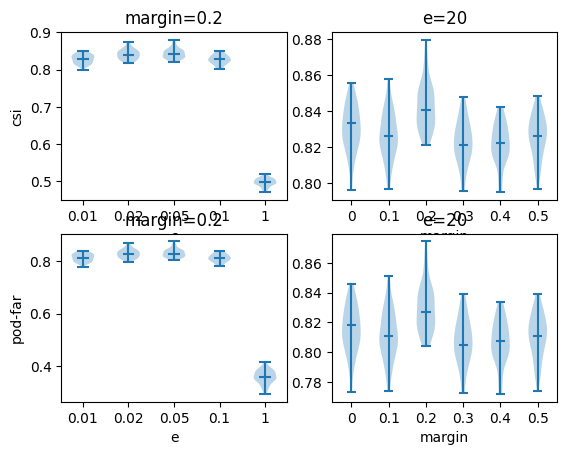

In [28]:
my_nn_struc_2nd_mont_intensity = scio.loadmat('my_nn_struc_2nd_mont_pcadim10_intensity_margin02.mat')
pod_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['pod_my_nn_mont']
far_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['far_my_nn_mont']
csi_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['csi_my_nn_mont']
e_s = [1,1/10,1/20,1/50,1/100]
plt.subplot(221)
plt.violinplot(np.fliplr(np.array(csi_my_nn_mont_intensity)), showmedians = True)
plt.xlabel('e')
plt.xticks(np.arange(5,0,-1),e_s)
plt.title('margin=0.2')
plt.ylabel('csi')
plt.subplot(223)
plt.violinplot(np.fliplr(np.array(pod_my_nn_mont_intensity-far_my_nn_mont_intensity)), showmedians = True)
plt.xlabel('e')
plt.xticks(np.arange(5,0,-1),e_s)
plt.title('margin=0.2')
plt.ylabel('pod-far')
my_nn_struc_2nd_mont_intensity = scio.loadmat('my_nn_struc_2nd_mont_pcadim10_intensity_e20.mat')
pod_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['pod_my_nn_mont']
far_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['far_my_nn_mont']
csi_my_nn_mont_intensity = my_nn_struc_2nd_mont_intensity['csi_my_nn_mont']
margin_s = [0,0.1,0.2,0.3,0.4,0.5]
plt.subplot(222)
plt.violinplot((np.array(csi_my_nn_mont_intensity)), showmedians = True)
plt.xlabel('margin')
plt.xticks(np.arange(1,7),margin_s)
plt.title('e=20')
plt.subplot(224)
plt.violinplot((np.array(pod_my_nn_mont_intensity-far_my_nn_mont_intensity)), showmedians = True)
plt.xlabel('margin')
plt.xticks(np.arange(1,7),margin_s)
plt.title('e=20')
# plt.savefig('./article/different_margin_e.pdf')

In [12]:
# 特征选择的方法6：用PCA先降维，然后一层线性NN来近似线性分类，用x_input的非线性项来近似残差，增加L1正则化项和L2正则化项
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import torch as t
from torch import nn
class NonLinear(nn.Module):
    def __init__(self,pca_dim_1,pca_dim_2) -> None:
        super().__init__()
        self.W = nn.Parameter(t.randn(pca_dim_1,1))
        self.b = nn.Parameter(t.randn(1))
        self.W_nonlinear = nn.Parameter(t.randn(pca_dim_2,1))#+in_features
        self.b_nonlinear = nn.Parameter(t.randn(1))
    def forward(self,x_feature,x_input):
        x = t.matmul(x_feature,self.W)
        y = x+self.b.expand_as(x)
        # x = t.concat([x_feature,x_input],dim=1)
        x = x_input
        y_nonlinear = t.relu(t.matmul(x,self.W_nonlinear)+self.b_nonlinear.expand_as(t.matmul(x,self.W_nonlinear)))
        return t.sigmoid(y+y_nonlinear),y,y_nonlinear
    def compute_regular_loss(self):
        return t.abs(self.W).sum()+t.pow(self.W_nonlinear,2).sum()+t.pow(self.b_nonlinear,2).sum()
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
def relu(x):
    y = np.clip(x, a_min = 0., a_max = None)
    return y
def my_nn(x_features_add_train,x_features_add_test,test_y,test_x):
    csi_s_test = []
    pod_s_test = []
    far_s_test = []
    for pca_dim_1 in range(2,25):
        my_nn_para_struc_2nd_intensity = scio.loadmat(f'my_nn_para_struc_2nd_intensity_para{pca_dim_1}_fixed_margin_e.mat')
        mu_all_dims = my_nn_para_struc_2nd_intensity['mu_all_dims']
        w_all_dims = my_nn_para_struc_2nd_intensity['w_all_dims']
        b_all_dims = my_nn_para_struc_2nd_intensity['b_all_dims']
        w_nonlinear_all_dims = my_nn_para_struc_2nd_intensity['w_nonlinear_all_dims']
        b_nonlinear_all_dims = my_nn_para_struc_2nd_intensity['b_nonlinear_all_dims']
        mu = mu_all_dims[pca_dim_1-2]
        w = w_all_dims[pca_dim_1-2]
        b = b_all_dims[0,pca_dim_1-2]
        w_nonlinear = w_nonlinear_all_dims[pca_dim_1-2]
        b_nonlinear = b_nonlinear_all_dims[pca_dim_1-2]
        predict_test = sigmoid(np.matmul(x_features_add_test-mu,w)+b+relu(np.matmul(test_x,w_nonlinear)+b_nonlinear))

        pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(predict_test>0.5,test_y.reshape(-1,1),1)
        pod_s_test.append(pod_)
        far_s_test.append(far_)
        csi_s_test.append(csi_)
    return pod_s_test,far_s_test,csi_s_test
pod_my_nn_mont = []
far_my_nn_mont = []
csi_my_nn_mont = []
for mont_i in range(len(calm_test_x)):
    test_x_i = np.vstack((calm_test_x[mont_i], pilot_test_x))
    test_x_features_i = test_traditional_feature(test_x_i)
    additional_features_test,_ = additional_features_cal(test_x_i)
    x_features_add_test_i = np.hstack((np.array(additional_features_test).T,test_x_features_i.reshape(-1,5)))#
    pod_s_test,far_s_test,csi_s_test = my_nn(x_features_add_train,x_features_add_test_i,test_y,test_x_i)
    pod_my_nn_mont.append(pod_s_test)
    far_my_nn_mont.append(far_s_test)
    csi_my_nn_mont.append(csi_s_test)
scio.savemat('my_nn_struc_2nd_mont_fixed_margin_e.mat',{'pod_my_nn_mont':pod_my_nn_mont,
                                             'far_my_nn_mont':far_my_nn_mont,
                                             'csi_my_nn_mont':csi_my_nn_mont})

d:\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
d:\anaconda\envs\pytorch_env\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


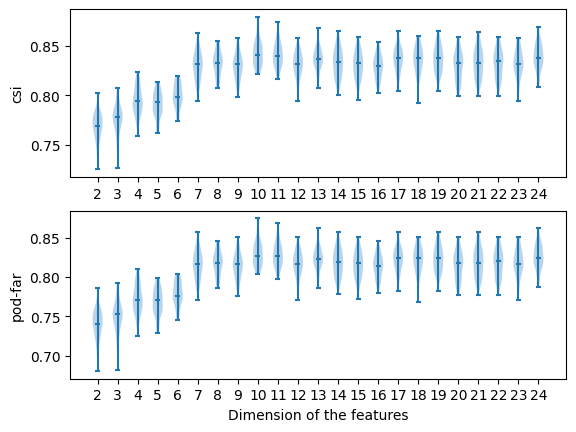

In [29]:
%matplotlib inline

my_nn_struc_2nd_mont = scio.loadmat('my_nn_struc_2nd_mont_fixed_margin_e.mat')
pod_my_nn_mont = my_nn_struc_2nd_mont['pod_my_nn_mont']
far_my_nn_mont = my_nn_struc_2nd_mont['far_my_nn_mont']
csi_my_nn_mont = my_nn_struc_2nd_mont['csi_my_nn_mont']

import matplotlib.pyplot as plt
plt.subplot(211)
plt.violinplot(csi_my_nn_mont, showmedians = True)
plt.xticks(np.arange(1,csi_my_nn_mont.shape[1]+1),labels=np.arange(2,csi_my_nn_mont.shape[1]+2))
plt.ylabel('csi')

plt.subplot(212)
plt.violinplot(pod_my_nn_mont-far_my_nn_mont, showmedians = True)
plt.xticks(np.arange(1,csi_my_nn_mont.shape[1]+1),labels=np.arange(2,csi_my_nn_mont.shape[1]+2))
plt.ylabel('pod-far')
plt.xlabel('Dimension of the features')
# plt.savefig('./article/different_dimension.pdf')

In [ ]:
# generalization cases
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import torch as t
from torch import nn
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
def relu(x):
    y = np.clip(x, a_min = 0., a_max = None)
    return y
def my_nn(x_features_add_test,test_y,test_x):
    pca_dim_1 = 10
    my_nn_para_struc_2nd_intensity = scio.loadmat(f'my_nn_para_struc_2nd_intensity_para{pca_dim_1}_fixed_margin_e.mat')
    mu_all_dims = my_nn_para_struc_2nd_intensity['mu_all_dims']
    w_all_dims = my_nn_para_struc_2nd_intensity['w_all_dims']
    b_all_dims = my_nn_para_struc_2nd_intensity['b_all_dims']
    w_nonlinear_all_dims = my_nn_para_struc_2nd_intensity['w_nonlinear_all_dims']
    b_nonlinear_all_dims = my_nn_para_struc_2nd_intensity['b_nonlinear_all_dims']
    mu = mu_all_dims[pca_dim_1-2]
    w = w_all_dims[pca_dim_1-2]
    b = b_all_dims[0,pca_dim_1-2]
    w_nonlinear = w_nonlinear_all_dims[pca_dim_1-2]
    b_nonlinear = b_nonlinear_all_dims[pca_dim_1-2]
    predict_test = sigmoid(np.matmul(x_features_add_test-mu,w)+b+relu(np.matmul(test_x,w_nonlinear)+b_nonlinear))
    pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(predict_test>0.5,test_y.reshape(-1,1),1)

    return predict_test, pod_, far_, csi_
def predict_my_nn(test_x,test_y):
    test_x_features = test_traditional_feature(test_x)
    additional_features_test,_ = additional_features_cal(test_x)
    x_features_add_test = np.hstack((np.array(additional_features_test).T,test_x_features.reshape(-1,5)))#
    predict_test,pod_test,far_test,csi_test = my_nn(x_features_add_test,test_y,test_x)
    plt.plot(predict_test,label='Combined-factor')
    plt.hlines(0.5,0,test_x.shape[0],label='Threshold')
    plt.legend()
    print(pod_test,far_test,csi_test)
def traditional(test_x_features,test_y):
    csi_s_test_thre = []
    far_s_test_thre = []
    pod_s_test_thre = []
    thres = [9,0.01,7.5,0.105,0.27]
    for feature_i in range(test_x_features.shape[1]):
        feature_test = test_x_features[::,feature_i]
        feature_test = feature_test.reshape(-1,1)
        pod_, far_, csi_, hss_, gss_, podN_ = calculate_stat(feature_test>thres[feature_i],test_y.reshape(-1,1),1)
        csi_s_test_thre.append(csi_)
        far_s_test_thre.append(far_)
        pod_s_test_thre.append(pod_)
    return csi_s_test_thre,far_s_test_thre,pod_s_test_thre

def predict_traditional(test_x,test_y):
    test_x_features = test_traditional_feature(test_x)
    csi_test,far_test,pod_test = traditional(test_x_features,test_y)
    plt.plot(test_x_features[::,-2],label='F-factor')
    plt.hlines(0.105,0,test_x.shape[0],label='Threshold')
    plt.legend()
    print(pod_test[-2],far_test[-2],csi_test[-2])

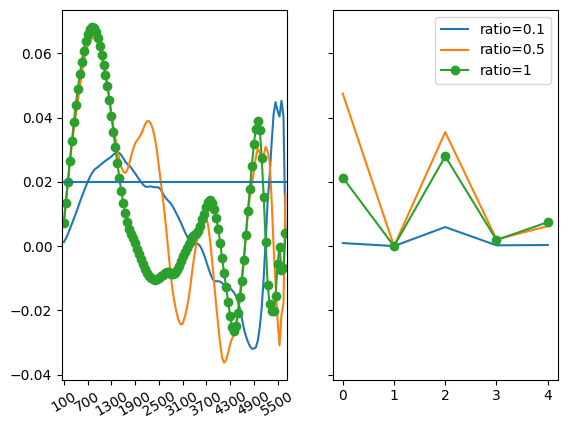

In [ ]:
#Explanation
import matplotlib.pyplot as plt
import scipy.io as scio
%matplotlib inline
from scipy import signal
fig,axs = plt.subplots(1,2,sharey=True)
my_nn_para_struc_2nd = scio.loadmat('my_nn_para_struc_2nd_intensity_para10_fixed_margin_e_ratio_01.mat')
mu_all_dims = my_nn_para_struc_2nd['mu_all_dims']
w_all_dims = my_nn_para_struc_2nd['w_all_dims']
b_all_dims = my_nn_para_struc_2nd['b_all_dims'][0]
w_nonlinear_all_dims = my_nn_para_struc_2nd['w_nonlinear_all_dims']
b_nonlinear_all_dims = my_nn_para_struc_2nd['b_nonlinear_all_dims']
axs[0].plot(w_all_dims[0][:113],label='ratio=0.1')
axs[1].plot(w_all_dims[0][113:],label='ratio=0.1')
my_nn_para_struc_2nd = scio.loadmat('my_nn_para_struc_2nd_intensity_para10_fixed_margin_e_ratio_05.mat')
mu_all_dims = my_nn_para_struc_2nd['mu_all_dims']
w_all_dims = my_nn_para_struc_2nd['w_all_dims']
b_all_dims = my_nn_para_struc_2nd['b_all_dims'][0]
w_nonlinear_all_dims = my_nn_para_struc_2nd['w_nonlinear_all_dims']
b_nonlinear_all_dims = my_nn_para_struc_2nd['b_nonlinear_all_dims']
axs[0].plot(w_all_dims[0][:113],label='ratio=0.5')
axs[1].plot(w_all_dims[0][113:],label='ratio=0.5')
my_nn_para_struc_2nd = scio.loadmat('my_nn_para_struc_2nd_intensity_para10_fixed_margin_e.mat')
mu_all_dims = my_nn_para_struc_2nd['mu_all_dims']
w_all_dims = my_nn_para_struc_2nd['w_all_dims']
b_all_dims = my_nn_para_struc_2nd['b_all_dims'][0]
w_nonlinear_all_dims = my_nn_para_struc_2nd['w_nonlinear_all_dims']
b_nonlinear_all_dims = my_nn_para_struc_2nd['b_nonlinear_all_dims']
axs[0].plot(w_all_dims[8][:113],label='ratio=1',marker='o')
axs[1].plot(w_all_dims[8][113:],label='ratio=1',marker='o')
plt.legend()
dist = []
for name_i in all_features_names[:113]:
    dist.append(50*(int(name_i[7:])))
# dist = dist+all_features_names[113:]

axs[0].set_xticks(ticks = np.arange(0,113,12), labels=dist[::12],rotation=30)
# plt.legend()
# plt.gca().add_patch(plt.Rectangle([0,-0.04],len(all_features_names),0.08, fill=True, alpha = 0.3,
#                   edgecolor='b', linewidth=1))
axs[0].set_xlim(-1,113)
axs[0].hlines(0.02,-1,113)
# plt.savefig('./article/explain_different_ratio.pdf')
plt.show()

In [24]:
import matplotlib.pyplot as plt
import scipy.io as scio
%matplotlib inline
from scipy import signal
fig,axs = plt.subplots(1,2,sharey=True)

my_nn_para_struc_2nd = scio.loadmat('my_nn_para_struc_2nd_intensity_para24_fixed_margin_e.mat')
mu_all_dims = my_nn_para_struc_2nd['mu_all_dims']
w_all_dims = my_nn_para_struc_2nd['w_all_dims']
b_all_dims = my_nn_para_struc_2nd['b_all_dims'][0]
w_nonlinear_all_dims = my_nn_para_struc_2nd['w_nonlinear_all_dims']
b_nonlinear_all_dims = my_nn_para_struc_2nd['b_nonlinear_all_dims']
for i in range(10,25,2):
    axs[0].plot(w_all_dims[i-2][:113],label=f'dimension={i}')
    axs[1].plot(w_all_dims[i-2][113:],label=f'dimension={i}')
plt.legend(ncol=2)
dist = []
for name_i in all_features_names[:113]:
    dist.append(50*(int(name_i[7:])))
# dist = dist+all_features_names[113:]

axs[0].set_xticks(ticks = np.arange(0,113,12), labels=dist[::12],rotation=30)
# plt.legend()
# plt.gca().add_patch(plt.Rectangle([0,-0.04],len(all_features_names),0.08, fill=True, alpha = 0.3,
#                   edgecolor='b', linewidth=1))
axs[0].set_xlim(-1,113)
axs[0].hlines(0.02,-1,113)
# plt.savefig('./article/explain_different_dimension.pdf')
plt.show()

SyntaxError: positional argument follows keyword argument (2713386441.py, line 14)

In [5]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import torch as t
from torch import nn
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
def relu(x):
    y = np.clip(x, a_min = 0., a_max = None)
    return y
def my_nn(x_features_add_test,test_x):
    pca_dim_1 = 10
    my_nn_para_struc_2nd_intensity = scio.loadmat(f'my_nn_para_struc_2nd_intensity_para{pca_dim_1}_fixed_margin_e.mat')
    mu_all_dims = my_nn_para_struc_2nd_intensity['mu_all_dims']
    w_all_dims = my_nn_para_struc_2nd_intensity['w_all_dims']
    b_all_dims = my_nn_para_struc_2nd_intensity['b_all_dims']
    w_nonlinear_all_dims = my_nn_para_struc_2nd_intensity['w_nonlinear_all_dims']
    b_nonlinear_all_dims = my_nn_para_struc_2nd_intensity['b_nonlinear_all_dims']
    mu = mu_all_dims[pca_dim_1-2]
    w = w_all_dims[pca_dim_1-2]
    b = b_all_dims[0,pca_dim_1-2]
    w_nonlinear = w_nonlinear_all_dims[pca_dim_1-2]
    b_nonlinear = b_nonlinear_all_dims[pca_dim_1-2]
    predict_test = sigmoid(np.matmul(x_features_add_test-mu,w)+b+relu(np.matmul(test_x,w_nonlinear)+b_nonlinear))
    return predict_test
def predict_my_nn(test_x):
    test_x_features = test_traditional_feature(test_x)
    additional_features_test,_ = additional_features_cal(test_x)
    x_features_add_test = np.hstack((np.array(additional_features_test).T,test_x_features.reshape(-1,5)))#
    predict_test = my_nn(x_features_add_test,test_x)
    # plt.plot(predict_test,label='Combined-factor')
    return predict_test
predict_test = predict_my_nn(pilot_test_x)

c:\work\work_in_2024\study\Traditional\traditional_methods.py:24: RuntimeWarning: invalid value encountered in power
  return 2*(1-0.5925485*x**(1/3)*kv(v, x))
c:\Users\78686\.conda\envs\my_pytorch\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [1]:
# Intensity assessment
import numpy as np
import random
from model_evaluation import *
from sklearn.metrics import roc_curve, auc
from scipy.special import kv #modified bessel function
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io as scio
from traditional_methods import traditional_methods
np.random.seed(1)
random.seed(1)
from Data_import import data_frame
Data = data_frame(standard = False)#
turb_ratio = 8
pilot_turb_mags = Data.pilot_turb_mags_test
pilot_ws_mags = Data.pilot_ws_mags_test
pilot_ws_mags[np.abs(pilot_ws_mags)>30] = 0
pilot_turb_mags[np.where(np.isnan(pilot_turb_mags))] = 0
pilot_mags_test = np.abs(pilot_ws_mags)+np.abs(pilot_turb_mags)*turb_ratio
pilot_turb_mags = Data.pilot_turb_mags_test
pilot_ws_mags = Data.pilot_ws_mags_test
pilot_turb_mags[np.where(np.isnan(pilot_turb_mags))] = 0
pilot_mags = np.vstack((np.abs(pilot_ws_mags.T), np.abs(pilot_turb_mags.T)))
pilot_mags_unique = np.unique(pilot_mags, axis=1)
pilot_mags_combine = np.abs(pilot_mags_unique[0,::])+np.abs(pilot_mags_unique[1,::])*turb_ratio
index_sort = np.argsort(pilot_mags_combine)
pilot_mags_unique = pilot_mags_unique[::,index_sort]


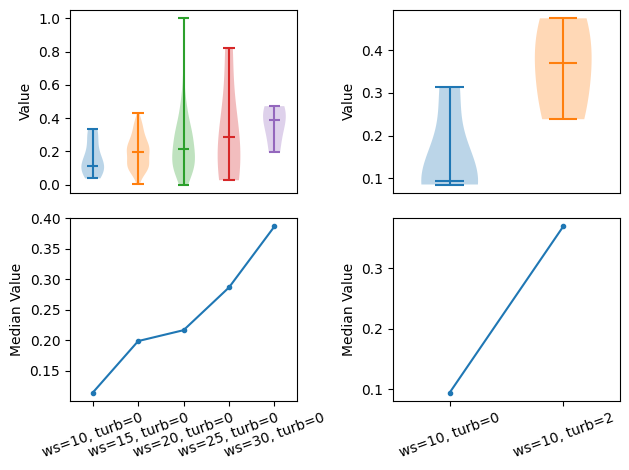

In [19]:
def inverse_sigmoid(s):
    x = -np.log(1/s-1)
    return x
def normalize(x):
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    return x
combined_factor = (inverse_sigmoid(predict_test))
combined_factor = normalize(combined_factor)
pilot_feature_mean = []
pilot_mag_names = []
ratio_mags = []
pilot_violin = []
%matplotlib auto
# predict_test[predict_test<0.5] = 1
plt.subplot(221)
for i_unique_mag in range(pilot_mags_unique.shape[1]):
    index_ws_mag = np.where((np.abs(pilot_ws_mags) == pilot_mags_unique[0, i_unique_mag])
                            & (np.abs(pilot_turb_mags) == pilot_mags_unique[1, i_unique_mag])
                            &(pilot_turb_mags==0))
    if (index_ws_mag[0].shape[0]>2):
        label_for_legend = f'ws={pilot_mags_unique[0,i_unique_mag]}, turb={pilot_mags_unique[1,i_unique_mag]}'
        pilot_feature_mean.append(np.nanmean(combined_factor[index_ws_mag[0]]))
        pilot_mag_names.append(label_for_legend)
        ratio_mags.append(np.percentile(combined_factor[index_ws_mag[0]],50))
        plt.violinplot(combined_factor[index_ws_mag[0]], [len(pilot_mag_names) - 1], showmedians=True)  #
        pilot_violin.append(combined_factor[index_ws_mag[0]])
plt.xticks(())
plt.xlim((-0.5, len(pilot_mag_names) - 0.5))
plt.ylabel('Value')
plt.subplot(223)
plt.plot(np.arange(len(pilot_mag_names)), ratio_mags, '-', marker='.')
plt.xticks(np.arange(len(pilot_mag_names)), (pilot_mag_names), rotation=20)
plt.ylabel('Median Value')
plt.xlim((-0.5, len(pilot_mag_names) - 0.5))

pilot_feature_mean = []
pilot_mag_names = []
ratio_mags = []
pilot_violin = []
# 
plt.subplot(222)
for i_unique_mag in range(pilot_mags_unique.shape[1]):
    index_ws_mag = np.where((np.abs(pilot_ws_mags) == pilot_mags_unique[0, i_unique_mag])
                            & (np.abs(pilot_turb_mags) == pilot_mags_unique[1, i_unique_mag])
                            &(((pilot_turb_mags==0)&(pilot_ws_mags==10))|((np.abs(pilot_turb_mags)==2)&(np.abs(pilot_ws_mags)==10))))
    if (index_ws_mag[0].shape[0]>2):
        label_for_legend = f'ws={pilot_mags_unique[0,i_unique_mag]}, turb={pilot_mags_unique[1,i_unique_mag]}'
        pilot_feature_mean.append(np.nanmean(combined_factor[index_ws_mag[0]]))
        pilot_mag_names.append(label_for_legend)
        ratio_mags.append(np.percentile(combined_factor[index_ws_mag[0]],50))
        plt.violinplot(combined_factor[index_ws_mag[0]], [len(pilot_mag_names) - 1], showmedians=True)  #
        pilot_violin.append(combined_factor[index_ws_mag[0]])
plt.xticks(())
plt.xlim((-0.5, len(pilot_mag_names) - 0.5))
plt.ylabel('Value')
plt.subplot(224)
plt.plot(np.arange(len(pilot_mag_names)), ratio_mags, '-', marker='.')
plt.xticks(np.arange(len(pilot_mag_names)), (pilot_mag_names), rotation=20)
plt.ylabel('Median Value')
plt.xlim((-0.5, len(pilot_mag_names) - 0.5))
plt.tight_layout()    

plt.savefig('./article/intensity_new_new.pdf')